# 67818 - Week 3

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix,distance
import random
import sqlite3
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,balanced_accuracy_score,accuracy_score,recall_score,precision_score,precision_recall_curve,plot_roc_curve,f1_score,cohen_kappa_score,roc_auc_score,auc
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from hyperopt import *
from scipy.optimize import minimize

import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LinearRegression

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score

plt.style.use('ggplot')


s=100
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18,8)


## Baselining


When trying to create or design solutions to any open-ended problem, modeling included, it is often dificult to find a suitable stopping point if one was not pre-defined. It's also important to understand whether or not our efforts have any impact- We could spend days hand crafting features and not have any idea whether our work had any effect.
<br> A good way to get a grasp on the effect of our efforts is to utilize baseline metrics.
<br> A baseline metric can be any metric we use to measure our 'progress'- for example, in a regression problem, we can compare our loss (MSE, for example) to the loss achieved by simply predicting the mean value for all the dependent values in our training set, or constatly predicting the most common class (or a random class) for a classification problem.
<br> Another option is trainig a 'naive' algorithm, using the most basic feature set, and measuring our result metric for it as a baseline.

In [2]:
conn = sqlite3.connect("example_db.db")
data = pd.read_sql("select * from titanic_data",conn)
conn.close()

In [3]:
data = data.drop(columns=["PassengerId","Name","Ticket","Cabin"]).dropna()
data = pd.get_dummies(data,columns=['Sex',"Embarked"],drop_first=True)
y=data["Survived"]
X= data.drop(columns=["Survived"])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### Predicting the most common train class

In [5]:
mode_prediction = np.ones_like(y_test)*y_train.mode()[0]
print(classification_report(y_test,mode_prediction))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       105
           1       0.00      0.00      0.00        73

    accuracy                           0.59       178
   macro avg       0.29      0.50      0.37       178
weighted avg       0.35      0.59      0.44       178



In [6]:
rf= RandomForestClassifier(n_estimators=10)
rf.fit(X_train,y_train)
print(classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       105
           1       0.77      0.64      0.70        73

    accuracy                           0.78       178
   macro avg       0.77      0.76      0.76       178
weighted avg       0.77      0.78      0.77       178



We see that we get a pretty good result without any real effort at all!<br>
Therefore, if we find ourselves working for a long time without any noticeable difference, we might want to try and switch up our efforts.<br>


# Loss Functions

A loss functions measures the incompatiability of the model output and the ground truth label, and it is used to train the model.


### Regression

Typically, for estimating the parameters of a linear regression model, the "mean squared error" loss function is used:

### $MSE=\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-f\left(x_{i}\right)\right)^{2} $


Another loss function which could be used is the "mean absolute error":

### $MAE=\frac{1}{n}\sum_{i=1}^{n}\left|y_{i}-f\left(x_{i}\right)\right|$

While the minimizer of the data's MSE is the average, the minimizer of the MAE is the median, making the MAE more robust to outliers. Therefore training a linear regression model by minimizing the MAE might yield a very different model then by minimzing the MSE:



In [7]:
sigma = 1
n = 50
x = np.random.uniform(-2, 7, n) 

y = -5 + 3*x + np.random.normal(scale=sigma ,size=n)

idx = [10, 30, 45]
y[idx] = y[idx] + 40

<AxesSubplot:>

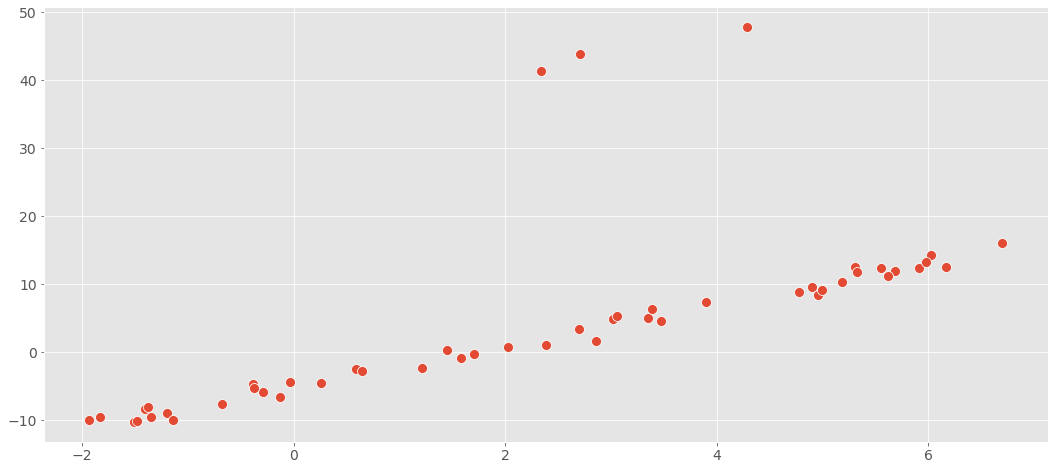

In [8]:
sns.scatterplot(x, y, s=s)

In [9]:
f = lambda X,w: X.dot(w)


def loss(w, X, y):
    mae =(np.abs(y - f(X, w))).mean()
    return mae


In [10]:
X_c = np.hstack((np.ones(x.size).reshape(-1,1), x.reshape(-1,1)))

In [11]:
opt = minimize(loss, np.zeros(2), args=(X_c, y))
w_robust = opt.x
preds_robust = f(X_c, w_robust)

In [12]:
reg = LinearRegression().fit(x.reshape(-1,1), y)
preds_ols = reg.predict(x.reshape(-1,1))

Text(0, 0.5, 'y')

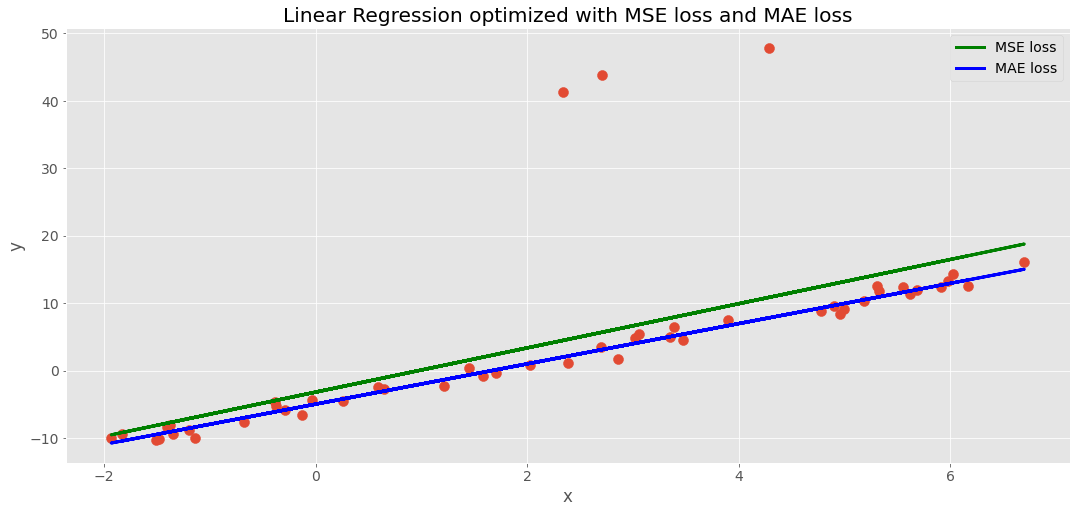

In [13]:
plt.scatter(x=x, y=y, s=s)
l1 = plt.plot(x, preds_ols, linewidth=3, color='green', label="MSE loss")
l2 = plt.plot(x, preds_robust, linewidth=3, color='blue', label="MAE loss")
leg = plt.legend()

plt.title("Linear Regression optimized with MSE loss and MAE loss")
plt.xlabel("x")
plt.ylabel("y")

We can see that the training  the linear model with the MAE loss yieled a model more robust to the outliers.

## Evaluation Metrics
In order to choose the best model for our original problem, we use evaluation metrics, which quantify the performance of the model.

* Unlike loss functions, they are not necessarily used directly for training the model.
* Used to evaluate the model performance in a way that relates to the original problem definition.



#### Rergession Evaluation Metrics
We will use a diabetes dataset, where the features are physiological quantities and the target is a quantiative measure of disease progression.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import load_diabetes


data = load_diabetes(as_frame=True)
df = data.frame
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-1.444295e-18,2.543215e-18,-2.255925e-16,-4.854086e-17,-1.428596e-17,3.898811e-17,-6.028360e-18,-1.788100e-17,9.243486e-17,1.351770e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


Besides using the MSE as a loss function for training the model, we can use it to evaluate the model's performance. It might actually be preferred to use the RMSE - the square root of the MSE, as it will be in the original units of the response variable, which might be more interpretable

In [15]:
df_train = df.drop(columns=['target'])
target = df['target']

df_train, df_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.3)

In [16]:
model_lreg = LinearRegression().fit(df_train, y_train)
model_gbr = GradientBoostingRegressor().fit(df_train, y_train)

In [17]:
rmse_lreg = np.sqrt(mean_squared_error(model_lreg.predict(df_test), y_test))
rmse_gbreg = np.sqrt(mean_squared_error(model_gbr.predict(df_test), y_test))


print("RMSE Gradient Boosting Regression: {:.2f}".format(rmse_gbreg))
print("RMSE Linear Regresson: {:.2f}".format(rmse_lreg))
print()

mae_lreg = mean_absolute_error(model_lreg.predict(df_test), y_test)
mae_gbreg = mean_absolute_error(model_gbr.predict(df_test), y_test)
print("MAE Gradient Boosting Regression: {:.2f}".format(mae_gbreg))

print("MAE Linear Regresson: {:.2f}".format(mae_lreg))

RMSE Gradient Boosting Regression: 61.87
RMSE Linear Regresson: 58.03

MAE Gradient Boosting Regression: 48.22
MAE Linear Regresson: 46.97


### $R^2$ metric
$R^2$ can be used to evaluate how good our regression model fits the data. 
It is the proportion of the variation in the dependent variable(the target y) that is predictable from the independent variables(the features)


## $R^2 = 1 - \frac{ \sum_{i} (y_i-f(x_i))^2  }{\sum_{i} (y_i - \bar{y})^2}$

$R^2 = 1$ when the model perfectly explains the variance in the training set - when the model perfectly fits it(might indicate overfitting)


In order to deal with the overfitting issue we can add a penalty for model complexity, which is called "Adjusted $R^{2}$"

#### Classification Evaluation Metrics

We will now use a different diabetes dataset, where now the target is whether the person is sick or healthy, so we have a binary classification problem. 

In [18]:
path = 'diabetes.csv'
cols = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
df = pd.read_csv(path, header=None, names=cols).drop([0])
df['label'].replace({"1": "sick", "0": "healthy"}, inplace=True)

df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
1,6,148,72,35,0,33.6,0.627,50,sick
2,1,85,66,29,0,26.6,0.351,31,healthy
3,8,183,64,0,0,23.3,0.672,32,sick
4,1,89,66,23,94,28.1,0.167,21,healthy
5,0,137,40,35,168,43.1,2.288,33,sick


<AxesSubplot:xlabel='label', ylabel='count'>

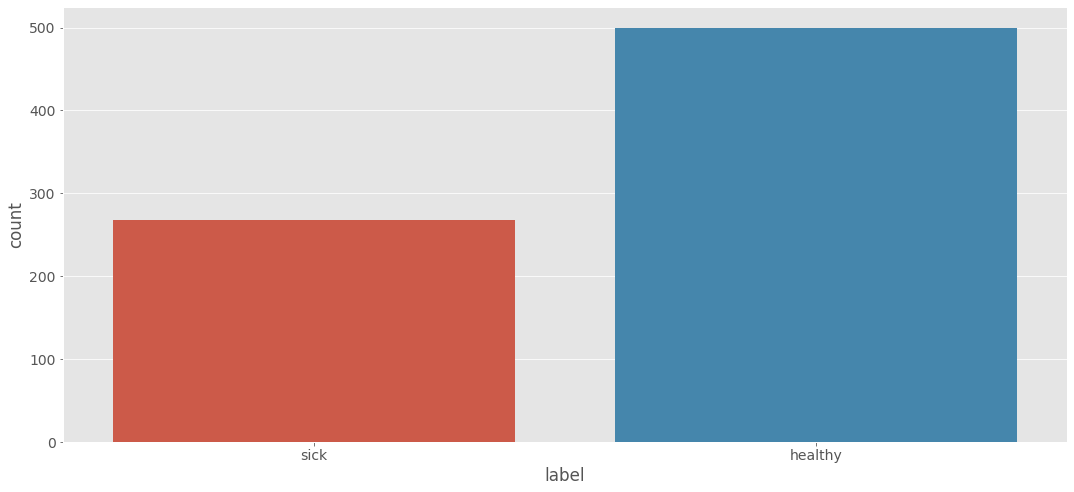

In [19]:
sns.countplot(data=df, x='label')

In [20]:
df.groupby(by='label').count()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
label,,,,,,,,
healthy,500,500,500,500,500,500,500,500
sick,268,268,268,268,268,268,268,268


Notice that there is some imbalance in the dataset - there are 232 more healthy people then sick.

Now, let's fit a logistic regression model:

In [21]:

features = ['pregnant', 'insulin', 'bmi', 'age']

X = df.drop(columns=['label'])
X = X[features]
y = df['label']

df_train, df_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
model = LogisticRegression().fit(df_train, y_train)

Now that we have trained the model, we would like to evaluate its performance. First, let's visualize with a confusion matrix:


![alt text](https://miro.medium.com/max/886/0*_fe41VT0HbBQuyB-.png)

[source](https://miro.medium.com/max/886/0*_fe41VT0HbBQuyB-.png)

1. **Binary Case**:
    - **True Positive (TP)**: The model *correctly* predicts (T) the Positive class (P).
    - **True Negative (TN)**: The model *correctly* predicts (T) the Negative class (N).
    - **False Positive (FP)**: The model *incorrectly* predicts (F) the Positive class (P). "Type I error"
    - **False Negative (FN)**: The model *incorrectly* predicts (F) the Negative class (N). "Type II error"


In [22]:
preds = model.predict(df_test)

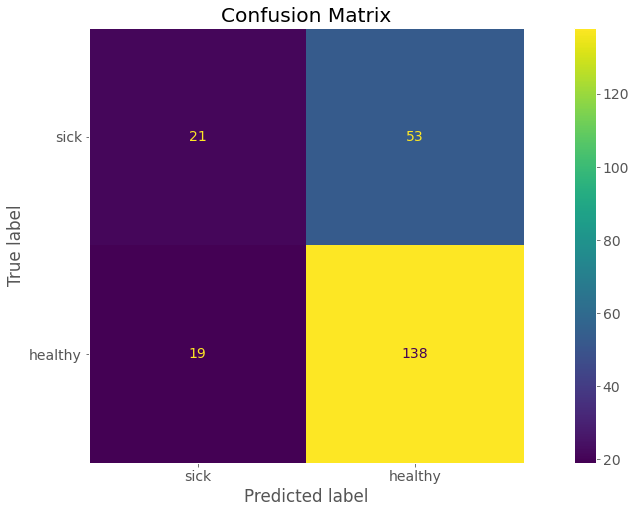

In [23]:
from sklearn.metrics import plot_confusion_matrix
conf_mat = plot_confusion_matrix(model, df_test, y_test, labels=["sick", "healthy"])
ax = conf_mat.ax_
_ = ax.grid(False)
_ = ax.set_title("Confusion Matrix")
#_ = ax.set_title("Non-Normalized Confusion Matrix")

#print(metrics.confusion_matrix(y_test, preds, labels=["sick", "healthy"]))
#plt.show()

In [24]:
print(classification_report( model.predict(df_test), y_test))

              precision    recall  f1-score   support

     healthy       0.88      0.72      0.79       191
        sick       0.28      0.53      0.37        40

    accuracy                           0.69       231
   macro avg       0.58      0.62      0.58       231
weighted avg       0.78      0.69      0.72       231



We can see that the classifier is doing badly on the "sick" class, which is the minority class - the number of false positives is quite high. This can be very problematic in case that we care alot about not predicting healthy people as sick(type I error).

More performance metrics:

## $ \text{Accuracy}=\frac{TP+TN}{TP+TN+FP+FN}=\frac{TP+TN}{\text{#samples}}$

The accuracy is the proportion of of correct predictions among all the data.
Accuracy might be problematic in the case of imbalanced dataset. For example, if the test set consists of 90% positive and 10% negative, then if the classifier constantly outputs "positive", according to the accuracy metric it will have 90% accuracy, even though the classifier is very naive. 
To handle that we can use balanaced accuracy:

### $\text{TPR}=\frac{TP}{P} $
### $\text{FPR}=\frac{FP}{N} $
### $\text{TNR}=\frac{TN}{N}  $

### $\text{Balanced Accuracy}=\frac{TPR + TNR}{2} $


In [25]:
acc = accuracy_score(y_test, preds)
bacc = balanced_accuracy_score(y_test, preds)
print("Accuracy: {:.4f}".format(acc))
print("Balanced Accuracy: {:.4f}".format(bacc))

Accuracy: 0.6883
Balanced Accuracy: 0.5814


We have seen in the confusion matrix that model performs bad on the minority class, so it makes sense that the balanced accuracy is worse then the regular accuracy.

This metric might be good to use when the performance on all of the classes is equally important.

**Recall**: The proportion of true positives among the real positives.
### $\text{recall}=\frac{TP}{P} $



**Precision**:  The proportion of true positives among what the classifier predicted as positive.
### $\text{precision}=\frac{TP}{TP + FP} $


In [26]:
recall = recall_score(y_test, preds, pos_label="sick")
precision = precision_score(y_test, preds, pos_label="sick")
print("recall: {:.4f}".format(recall))
print("precision: {:.4f}".format(precision))

recall: 0.2838
precision: 0.5250


To help understand the tradeoff between the two, let's use our diabeters data:

<AxesSubplot:xlabel='Glucose', ylabel='BMI'>

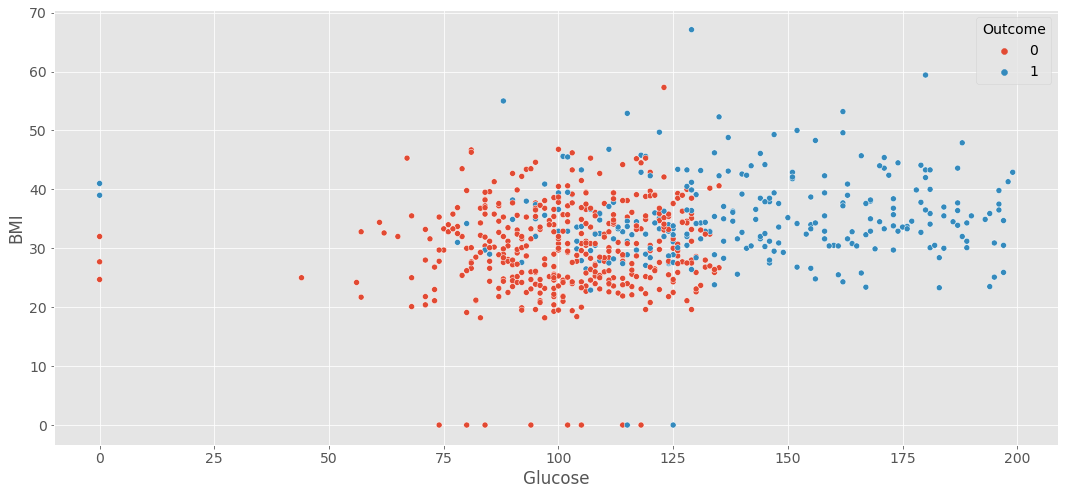

In [27]:
tdf  = pd.read_csv("comfort_diabetes.csv")
sns.scatterplot(data=tdf[["Glucose","BMI","Outcome"]],x='Glucose',y='BMI',hue='Outcome')

There is a tradeoff between recall and precision - increasing recall, which will decrease the false negatives and increase the true positives, may increase the number of false positives, and therefore decreasing the precision. We can visualize this tradeoff with a precision-recall curve, which plots precision vs recall by varying the classification threshold. 

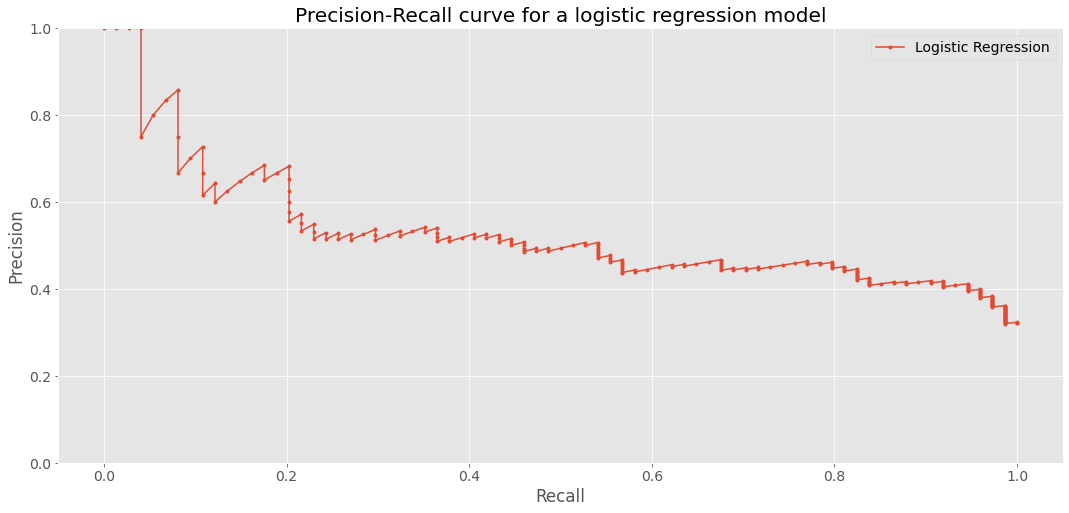

In [28]:
probas = model.predict_proba(df_test)

precision, recall, _ = precision_recall_curve(y_test, probas[: ,1], pos_label="sick")
plt.plot(recall, precision, marker='.', label="Logistic Regression")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0,1])
plt.legend()
plt.title("Precision-Recall curve for a logistic regression model")
plt.show()


Another metric, which considers both precision and recall is the **F1-score**, which is the harmonic mean of precision and recall:


### $ F_{1}=2\cdot \frac{precision \cdot recall}{precision + recall} $

The best score is 1, and the worst is 0.

This is a special case of the $F_{\beta}$ score:

$ F_{\beta} = (1 + \beta^{2}) \cdot \frac{precision \cdot recall}{\beta^{2} \cdot precision + recall}$

We can tradeoff between precision and recall by varying $\beta$: higher $\beta$will prioritze recall more, and a $\beta=1$ corresponds to $F_{1}$ which gives precision and recall equal importance.

As $F_1$ and PR AUC metrics both consider precision and recall, they can be a good choice for imbalanced datasets.

In [29]:
f_1 = f1_score(y_test, preds, pos_label="sick")
print('F1 score: {:.4f} '.format(f_1))

F1 score: 0.3684 


Note that most algorithms do not necessarily provide a class, but a potential probabilty of inclusion in a certain class, and a threshold (>.5) is used to determine class inclusion.

We can make use of this fact to tune our algorithm's result:

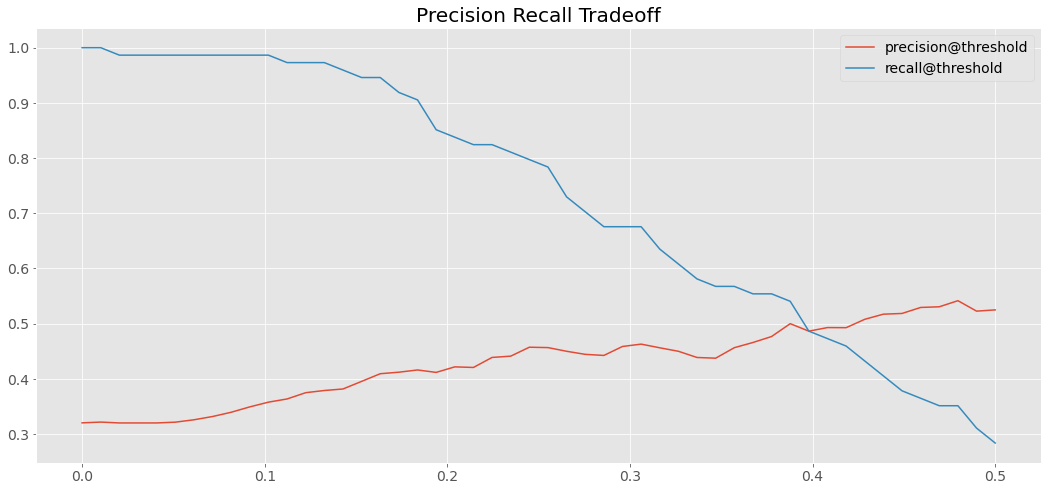

In [30]:
precisions=[]
recalls=[]
thresholds = np.linspace(0,.5)
for i in thresholds:
    predictions = probas[:,1]>i
    
    precisions.append(precision_score(y_test=='sick',predictions))
    recalls.append(recall_score(y_test=='sick',predictions))
plt.plot(thresholds,precisions,label='precision@threshold')
plt.plot(thresholds,recalls,label='recall@threshold')
plt.title("Precision Recall Tradeoff")
plt.legend()
plt.show()

Notice that the area under the curve(AUC) is large when both recall and precision are high, this brings us to the **AUC of a precision recall curve** metric, which we want to be high, as high values corresponds to both high recall and precision:

In [31]:
auc_score = auc(recall, precision)
print("AUC score: {:.4f}".format(auc_score))

AUC score: 0.5273


Another metric is the **ROC Curve**, which plots the TPR(true positive rate) vs FPR(false positive rate) when varying the classification threshold, we can calculate its associated AUC too.

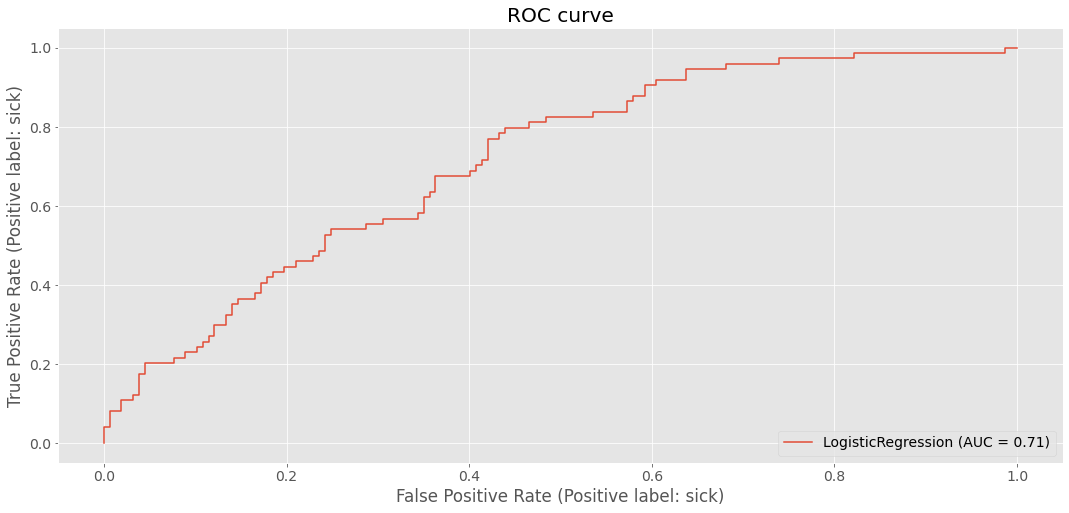

In [32]:
_ = plot_roc_curve(model, df_test, y_test)
_ = plt.title("ROC curve")

Another point of intution for ROC-AUC is the model's measure of seperability between datapoints of different classes.

As we have the probabilities for each data point to be either True or False, we can order our datapoints based on these probabilities.

The AUC is the probabilty that, given such an ordering, our classifier will give a positive datapoint a higher True probability than a random negative datapoint. This is threshold invariant:

In [33]:
first_trues = [.9 for i in range(5)]
second_trues = [.7 for i in range(5)]
falses = [.3 for i in range(6)]
labels = [1 for i in range(5)] + [0 for i in range(6)]
print(roc_auc_score(labels,first_trues+falses),roc_auc_score(labels,second_trues+falses))

1.0 1.0


Yet if we were to increase one of the false values to .8:

In [34]:
falses[2] = .8

In [35]:
print(roc_auc_score(labels,first_trues+falses),roc_auc_score(labels,second_trues+falses))

1.0 0.8333333333333334


# Hyperparameter Optimization

Hyperparameters(HPs) are parameters which are usually set before the training, and are used to control the learning process.

Examples:
* Learning rate in gradient descent
* Regularization in ridge regression
* Maximal depth of a decision tree
* The number of trees in a random forest
* ...


Choosing the right HPs can be a tricky process, and it can greatly effect the model's performance.
It is possible to manually tune the HPs, but it tedious and will mostly lead to sub-optimal perfomrance.
Therefore, we would mostly prefer to use hyperparameter optimization - an automated process for choosing the optimal hyperparameters such that our learning algorithm gives us an optimal model.



We can think of HPO as an optimization problem of a black box function, as unlike optimization of a regular loss function, in HPO we optimize a score function(e.g. the F1 score on the validation set, or some other metric we discussed previously) which is not differentiable, with respect to hyperparameters. 

HPO methods can be categorized into model free and model based methods.

We will start with some basic model free based methods:

## Grid Search
This is one of the most basic HPO methods, which works as follows:
* For each hyperparameter - set some specified values
* Train the learning algorithm on each tuple from all their possible combinations
* Evaluate the performance of each of the trained models(e.g cross validation)
* Choose the best tuple of hyperparameters




If we have 2 hyperparameters - $ (\alpha, \beta) $


$ \alpha=\{5, 10\} $


$ \beta=\{1, 2, 3\} $

The grid will be:

(5, 1)

(5, 2)

(5, 3)

(10, 1)

(10, 2)

(10, 3)

## Random Search
* Instead of trying all possible combinations - randomly select values for a combination
* Might perform better than grid search, depending on how many hyperparameters actually effect the performance.

![alt text](https://miro.medium.com/max/1000/1*9W1MrRkHi0YFmBoHi9Y2Ow.png "Title")

Random search will sample more instances of the important parameter, and therefore performs better.


Let's try to optimize the HPs of a random forest on titanic, optimizing specifically for balanced accuracy.

In [36]:
from sklearn import preprocessing


data = pd.read_csv("titanic_train.csv")

le = preprocessing.LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])


features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

data = data[features + ['Survived']]
data = data.dropna()

y = data['Survived']
X = data[features]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

model = RandomForestClassifier(random_state=10)


params_grid = { 
    'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256],
    'min_samples_leaf': [2, 4, 8, 16],
    'min_samples_split': [2, 4, 8, 16, 32],
}

n_configs = np.array([len(l) for key, l in params_grid.items()]).prod()
print('n_configs', n_configs)

grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=5, verbose=1, scoring=make_scorer(balanced_accuracy_score))

grid.fit(X_train, y_train)

print("Done grid search")

n_configs 160
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Done grid search


In [38]:
print('Best parameters found in Grid Search', grid.best_params_)
print('Best score in Grid Search', grid.best_score_)
model_gs = grid.best_estimator_

Best parameters found in Grid Search {'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 4}
Best score in Grid Search 0.7869766686405056


In [40]:
from scipy.stats import randint

model = RandomForestClassifier(random_state=10)

dists = { 
    'n_estimators': randint(2, 256),
    'min_samples_leaf': randint(2, 16),
    'min_samples_split': randint(2, 32)
}

rs = RandomizedSearchCV(estimator=model, param_distributions=dists, cv=5, verbose=1, scoring=make_scorer(balanced_accuracy_score), n_iter=n_configs)

rs.fit(X_train, y_train)

print("Done random search")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Done random search


In [41]:

print('Best parameters found in Random Search', rs.best_params_)
print('Best score in Random Search', rs.best_score_)
model_rs = rs.best_estimator_

Best parameters found in Random Search {'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 11}
Best score in Random Search 0.7867595463520761


In [42]:
bac_rs = balanced_accuracy_score(y_test, model_rs.predict(X_test))
bac_gs = balanced_accuracy_score(y_test, model_gs.predict(X_test))
print('BAC on test set - random search: ', bac_rs)
print('BAC on test set - grid search: ', bac_gs)

BAC on test set - random search:  0.8044005544005544
BAC on test set - grid search:  0.7969074844074844


(note that on default, the best_estimator_ field is the model refitted on **all** of the data, after finding the best set of HPs.

# Bayesian Optimization
As an alternative to grid and random search, we can use model based methods, such as Bayesian Optimization(BO).

BO works by evaluating a set of HPs, and according to the model performance with these HPs, it decides which HPs to evaluate next, in a sequential manner.

We will use the hyperopt package for performing BO.

In order to perform HPO with hyperopt - we define a distribution over the hyperparameters, and an objective function to be optimized, here the balanced accuracy on the validation set.

In [ ]:
optuna.Trial.suggest_int()

In [85]:
import optuna

def objective(trial):
    
    params={}
    params['n_estimators'] = trial.suggest_int('n_estimators', 2, 4000)
    params['max_depth'] = trial.suggest_int('max_depth', 5, 15)
    params['criterion'] = trial.suggest_categorical('criterion',['gini','entropy'])
    model = RandomForestClassifier(random_state=50, **params)
    res = cross_val_score(model, X_train, y_train, scoring='f1',cv=5).mean()
    return res

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Best score: {}'.format(trial.value))




[I 2022-11-09 13:38:21,866] A new study created in memory with name: no-name-9fa3cdc3-b0b6-4f46-a024-013b8ba9ff7d
[I 2022-11-09 13:38:21,946] Trial 0 finished with value: 0.7135916096287611 and parameters: {'n_estimators': 12, 'max_depth': 14, 'criterion': 'gini'}. Best is trial 0 with value: 0.7135916096287611.
[I 2022-11-09 13:38:22,101] Trial 1 finished with value: 0.7171180146522611 and parameters: {'n_estimators': 35, 'max_depth': 5, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7171180146522611.
[I 2022-11-09 13:38:22,211] Trial 2 finished with value: 0.7098236423578889 and parameters: {'n_estimators': 22, 'max_depth': 6, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7171180146522611.
[I 2022-11-09 13:38:22,371] Trial 3 finished with value: 0.7302893013419329 and parameters: {'n_estimators': 34, 'max_depth': 10, 'criterion': 'gini'}. Best is trial 3 with value: 0.7302893013419329.
[I 2022-11-09 13:38:22,491] Trial 4 finished with value: 0.7134456963328643 and pa

Best score: 0.737069016872531


We can also include preprocessing as a HP, for example - scaling(even though scaling isn't supposed to effect RF performance).

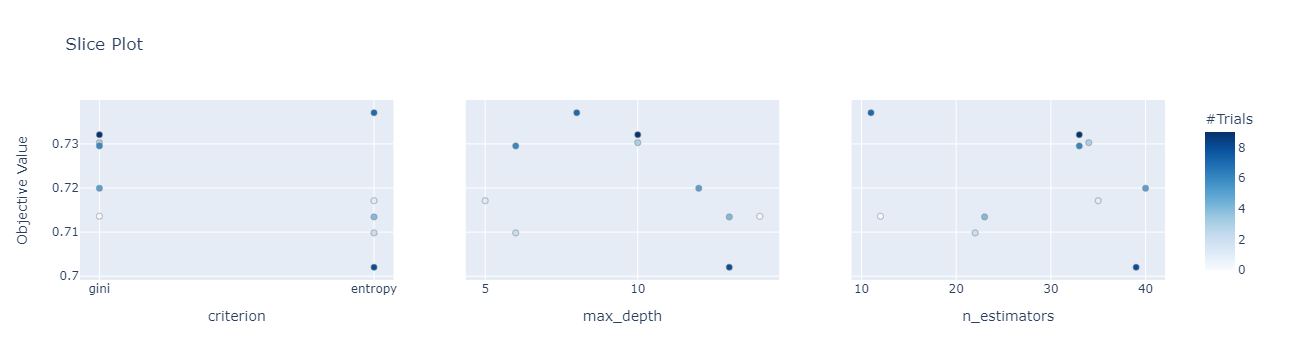

In [86]:
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances


plot_slice(study)

We can also use some evaluation function to determine which hyperparameter affected tuning and improvement more.

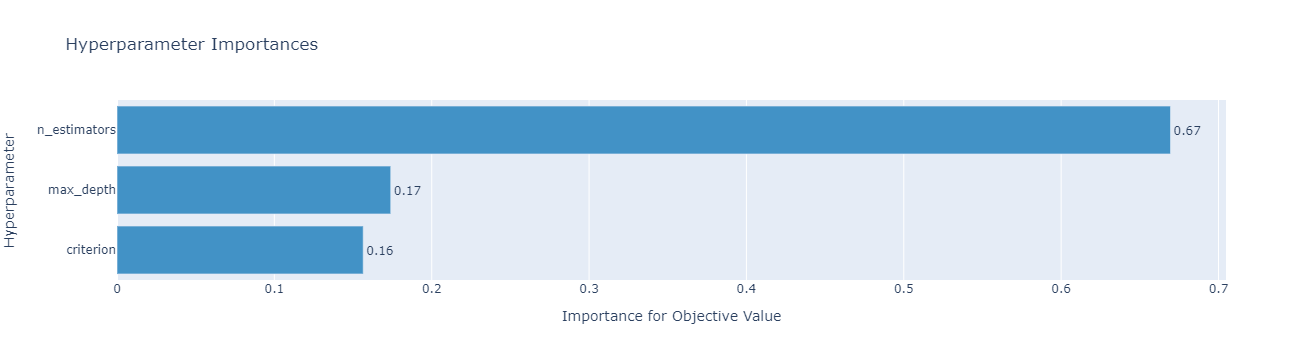

In [53]:
plot_param_importances(study)


We can also include in the HPO various learning algorithms to choose from, each with its own possible HPs.

When deciding on a HP method, we should consider the following factors:
* Discrete, continuous HPs: some BO methods might struggle with discrete HPs.  

* Compute - can we parallelize: search based methods may work faster then BO with paralleization resources, as they don't work sequentially based on previous results.

## Cross Validation

Moving on to a (not so) new concept, let's talk anout cross validation.
<br>As a reminder, when training machine learning algorithms, we wish to measure an expected level of generalization for our algorithm- which is the reason that we perform a train-test split before training. However, in the process of working on our algorithm, we may find ourselves wanting a more 'robust' expression of the model's performance, or needing to tune different hyperparameters of our model.
<br> Hyperparameters are, simply put, parameters pretaining to our model rather than our data- the amount of decision tress used in an ensemble, the level of regularization used in a linear model and the amount of clusters used when performing k-means clustering are all hyperparameters.
<br> Take a moment to consider whether we'd like to tune these on the test set or not.
<br><br>
The result you've probably came to is that we probably should not - as this could lead a model whose parameters aren't necessarily best-fitted to unseen test data.  This ties in to our earlier point about requiring more robust metrics describing our model's performance. This is where cross validation comes in.
<br> The general idea is rather simple- we use the same model settings to train over several different parts of our training data, and look at the required metric over each unused part. For example, we split our training data into 5 parts, and train five models- each on 4 parts- and measure their performance over the unused part of our training data. We then observe the results for all 5 models.
<br> This method of cross validation is also called k-fold cross validation.
<br> We should also make note of the fact that this is (usually) a naive way to split our data- as we might (rightfully) want to keep the class representation consistent throughout different folds. This is calld Stratified k-fold cross validation, and is quite usefull in multiclass or non balanced cases. 



![link text](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)



In [54]:
from sklearn.model_selection import cross_validate,StratifiedKFold
from sklearn.metrics import accuracy_score

In [55]:
rf= RandomForestClassifier(n_estimators=10)
scoring = ['accuracy','precision']
cross_validate(rf,X_train,y_train,cv=5,scoring=scoring)

{'fit_time': array([0.01196027, 0.01096606, 0.01095867, 0.01048756, 0.00996208]),
 'score_time': array([0.00298691, 0.00199389, 0.00299072, 0.00199342, 0.00199342]),
 'test_accuracy': array([0.71      , 0.79      , 0.8       , 0.77      , 0.82828283]),
 'test_precision': array([0.64516129, 0.72222222, 0.79310345, 0.75      , 0.76315789])}

In [56]:
accuracies= []
skf = StratifiedKFold(5)

In [57]:
for train_index, test_index in skf.split(X_train, y_train):

     x_trn  = X_train.iloc[train_index]
     x_tst= X_train.iloc[test_index]
     y_trn = y_train.iloc[train_index]
     y_tst = y_train.iloc[test_index]
     rf= RandomForestClassifier(n_estimators=10)
     rf.fit(x_trn,y_trn)
     accuracies.append(accuracy_score(y_tst,rf.predict(x_tst)))

In [58]:
accuracies

[0.73, 0.82, 0.82, 0.78, 0.8484848484848485]

## Hypothesis testing

Now that we are aware of the metrics we measure in order to assert our models' worth, let's talk about the concept of significance.

First, we measured the results given by a single model, and then moved on to several iteration of the same model parameters by using cross validation. We've used the 'mean metric' heuristic. But we disregard the concept of variance. If we attempt to simulate the distribution of accuracy, for example, for two different model configurations, we might find that their distribution overlap and one model configuration could potentially be "better" than another.

To address this problem, let's talk about hypothesis testing. First, a statistical hypothesis is a  testable hypothesis based on observations of realised instances of random variables. Hypothesis testing is the process of formulating such hypotheses, assigning them some test statistic, and testing whether or not these hypothesis (or assumptions) hold.

A hypothesis test requires two general hypothesis- the null hypothesis, which we try to refute, and the alternative. We use the observed data to calculate the required statistic (dependent of the test), and make a decision using its value.

As an example, we'll talk about one of the most well known tests- the T-test- which tests the mean of a given distribution. For example, we could use the t-test to check whether we could reject the hypothesis of a the true mean of a distribution of a sample is lower or higher than some value (single sample t-tests) or between two samples (two sample t-tests). More practically, we can use this test to check whether the mean accuracy for one algorithm is higher or lower than another's.

The t-test's statistics is calculated as such:


![link text](https://wikimedia.org/api/rest_v1/media/math/render/svg/eeecf40c622f1fa6b0fb9462c7c4b7030cbb47eb)

With:

![link text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5024dd38e905d60353a324af2a05058fdd4ac3e7)


In [59]:
data = pd.read_csv("titanic_train.csv")

le = preprocessing.LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])


features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

data = data[features + ['Survived']]
data = data.dropna()

y = data['Survived']
X = data[features]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [70]:
scoring = ['accuracy','precision']
rf= RandomForestClassifier(n_estimators=25)
rf_score = cross_validate(rf,X_train,y_train,cv=50,scoring=scoring)
lm= LogisticRegression()
lm_score = cross_validate(lm,X_train,y_train,cv=50,scoring=scoring)

To gain a bit of intuition, let's talk about the results as seen here:

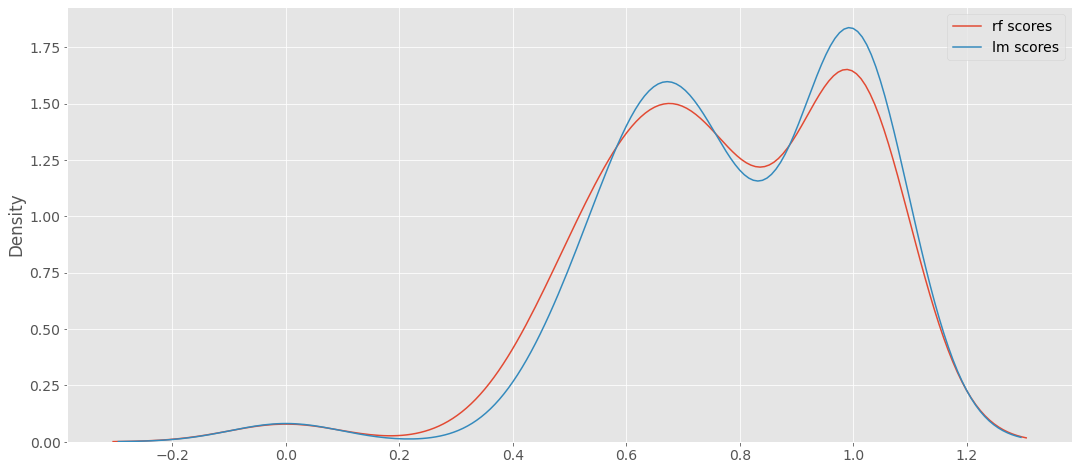

In [73]:
sns.kdeplot(rf_score['test_precision'],label='rf scores')
sns.kdeplot(lm_score['test_precision'],label='lm scores')
plt.legend()

In [61]:
from scipy.stats import ttest_ind

In [62]:
acc_ttest=ttest_ind(rf_score['test_accuracy'],lm_score['test_accuracy'],alternative='greater',equal_var=False)
prec_ttest=ttest_ind(rf_score['test_precision'],lm_score['test_precision'],alternative='greater',equal_var=False)

In [63]:
acc_ttest.statistic,prec_ttest.statistic

(-0.5605392169350072, -0.02635754649756441)

What are we seeing here?

We've established that a hypothesis test is based on the distribution of a test statistic. In the t-test's case, we use (somewhat unsurprisingly) the student's t distribution.

But what do we do with this value?

This is where we first encounter the concept of the p-value. Now that we have a statitic under some assumed distribution, we can now check whether or not this value is "extreme". The underlying logic is that, if we're testing a lower alternative hypothesis, if there's a very small chance (=probability) for getting a smaller value, we can reject the null hypothesis. Note that this doesn't mean we have to accept the alternative. 
Rejecting the null hypothesis requires some threshold, under which we actually reject using the pval, which is case-dependent but usually asserted as 0.05. This is also called the significance level.

In [419]:
acc_ttest.pvalue,prec_ttest.pvalue

(0.1416295440789965, 0.06550054527222345)

Things we should note: As mentioned, the t-test has some underlying assumptions about the distribution our data comes from (i.e normality), which don't always hold and as such different tests should be used (like the Mann-Whitney test). This should be taken into account when performing such tests.


Hypothesis testing is an extremely powerful tool if we can define our hyopthesis well, and applications can be found everywhere- for example, in week one we talked about data cleaning strategies. 
When we wanted to fix problems with our data, we could make use of hypothesis testing to check whether our solutions 'make sense'- i.e come from the same distribution as the supposed 'clean' or 'correct' data. 

This kind of tests is called 'goodness of fit' tests, and some examples for them include the chi squared tests (which surprisingly utilizes the chi squared distribution for the test statistic) for categorical data and the Kologmorov-Smirnov two sample test for continuous data. Both use the null hypothesis for which the two samples come from the same distribution.

## Fitting features to models

<br> And now for something completley different.
<br> Something we should keep in mind, now that we've gone through the process of feature engineering and model hyperparameter tuning, is the way our features describe and fit the model.
<br> To go into more depth- not all features and models interact in the same way.
<br> As an example, let's take any tree-based model (say, Random Forest) and a linear model. 


In [47]:
a = np.random.random(100)*10
e = np.random.random(100)*5 - 2
b = a+10
c = a*1.1 + np.random.random(100)-0.5
c[[5,7,11,29,37,61,83,99]] = -1
d = np.random.random(100).round()
fake_data = np.hstack([a.reshape((-1,1)),b.reshape((-1,1)),c.reshape((-1,1)),d.reshape((-1,1)),e.reshape((-1,1))])

<AxesSubplot:>

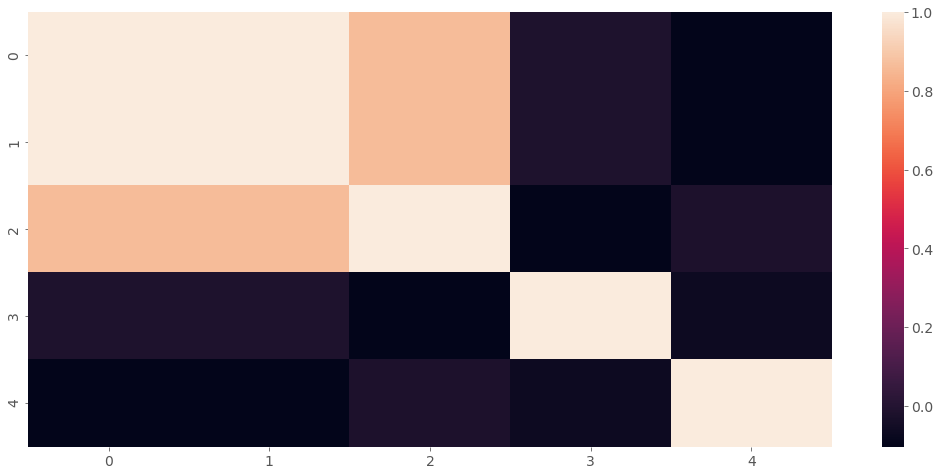

In [48]:
sns.heatmap(pd.DataFrame(fake_data).corr())

## Learning Trees

Before we go on, let's take a second to talk about learning decision trees.

Basically speaking, decision trees function as good, human like heuristic. Given some data and loss function, a decision tree greedly looks for a split in our given dataset that minimizes the loss function locally (i.e, for the data present before the current split), and each leaf returns the mean value for the traning datapoints that ended up in it.

This is more trivial for regression problems- we can simply split by the MSE- but to understand how this method functions for classification problems we'll introduce the concept of entropy.

Given a dataset with label set $i\in S$, the entropy for our dataset is calculated as $E=-\sum p_i log(p_i)$

As an example for intution, let's calculate this for a few datasets- one with equal probabilities for true and false, and some with a skewed probability.


In [80]:
def entropy(p_true):
    to_sum =[p*np.log2(p) for p in [p_true,1-p_true]]
    return -sum(to_sum)

print(entropy(.5),entropy(.7),entropy(.999))

1.0 0.8812908992306927 0.011407757737461145


We see that when we get more 'pure' or label-homogenous dataset, our entropy lowers.

Therefore, we can set our loss to be the entropy retained in our dataset after each split. This concept is referred to as Information Gain, which is roughly the reduction in entropy given obtained by a split. 

Decision Trees may also use a metric called the gini index (not to be confused with the wealth inequality measure), which achieve similar results. We'll talk about it next week.

<img src="https://miro.medium.com/max/1838/1*Udn4H4-JgG_Ga8NWaV3WNQ.png" width="500" height="400">

## Gradient Boosting


As a final treat, we're going to talk about a specific class of algorithms that's useful to know- the gradient boosted decision trees.
<br> First, a reminder- gradient boosted decision trees is a type of boosting algorithm, which is a type of an ensemble learning algorithm.
<br> In machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than, hopefully, what could be obtained by any of the learning algorithms by themselves.
<br>Boosting relies on successive learning of our base algorithm- in IML, you've seen adaboost as an example. VERY generally put, gradient boosted decision trees work by fitting, in any iteration m, a new decision tree to the residual value yielded by the last trained tree. <br>Regulatization is maintained by using a learning rate hyperparameter to adjust the importance of later added decision trees.


![link text](http://uc-r.github.io/public/images/analytics/gbm/boosted_stumps.gif)


<br>This differs from bagging ensembles, which use parallel models rather than consecutive models, like Random Forest.

Gradient boosting has become "all the rage" in the last couple of years due to its unreasonably solid performance for tabular data, which is why it's useful to get to know.<br> Common implementations of gradient boosting include XGBoost, CatBoost and LGBM- each with its own niche and useful features. For example, LGBM and catboost both have built-in methods for dealing with categorical features (catboost using a combination of one-hot encoding and target enconding which we've discussed last week). To spare you the minutiae of model specifics, we encourage you to go read about htem- they could prove useful later.